
<p  style="font-size: 3rem; font-weight: bold; text-align: center;"> Tutorial: Introduction to Data Analysis and Machine Learning</p>

<p style="font-size: 2rem; font-weight: bold; text-align: center;"> Kai A. Brügge & Maximilian Nöthe</p>

<p style="font-size: 1.5rem; font-weight: bold; text-align: center;"> DPG Früjahrstagung Aachen 2019</p>

<img width="200px" src="https://www.dpg-physik.de/vereinigungen/fachuebergreifend/ak/akpik/pix/logo-ak-pik_blue.png"/>


> __People worry that computers will get too smart and take over the world, but the real problem is that they're too stupid and they've already taken over the world.__

> Pedro Domingos 


In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

In [ ]:
%%html
<style>
.important
{
     margin: 0 auto;
     width: 66%; 
     background-color: linen;
}
</style>



Do not delete, math definitions here
$$
% vectors and matrices
\def\v#1{\boldsymbol{#1}}
\def\m#1{\boldsymbol{#1}}
% confusion matrix stuff
\def\TP{\mathit{TP}}
\def\TN{\mathit{TN}}
\def\FP{\mathit{FP}}
\def\FN{\mathit{FN}}
\def\mse{{\rm mse}}
\def\E{{\rm E}}
\def\Var{{\rm Var}}
\def\Bias{{\rm Bias}}
\def\T{\mathtt{True}}
\def\F{\mathtt{False}}
$$


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Supervised Machine Learning


## Mathematical Notation and Problem Description

*For more details see "Elements of statistical Learning" by Trevor Hastie.
(Available for free here: http://web.stanford.edu/~hastie/ElemStatLearn/)* 

We will try to follow some naming conventions along this notebook.
They are the same as in the book (for the most parts).

* Uppercase letters such as $X$ or $Y$ denote generic aspects of a variable (i.e. the actual random variable)
* Observed values are written in lowercase. The ith observed value of $X$ is written as $x_i$
* Matrices are written in bold uppercase letters $\m{X}$
* Observations map as *rows* in the matrix while the observed variables are the *columns*.

So if we measure two observables $p = 2$ the size and weight of $N = 100$ people, we get an $N \times p$ matrix $\m{X}$.

One observation in that matrix is denoted as $\v{x}_i = [\mathrm{size}, \mathrm{weight} ]$,
while all observations of the variable size are denoted by $\v{x}_j$ 


One possible definition of supervised machine learning:

> Given a $N \times p$ matrix $\m{X}$ and some associated output vector $Y \in \mathbb{R}^N$,
 find a function $f(X) = \hat{Y}$ that takes a vector $X \in \mathbb{R}^p$ and returns a prediction for $\hat{Y}$
 where some "loss function" $L(Y, f(X))$ is minimized for all $X$.
 

Applied to our example from above, supervised machine learning could be used to solve the following problem:

> Given a $N \times p$ matrix $\m{X}$ containing the size and weight of 100 people and an associated vector $Y$    
 containing their age.
 Find a function $f(X) = \hat{Y}$ that takes the size and weight of a new person and returns a prediction for their age $\hat{Y}$.



## The Titanic Example. Learning from disaster.

In the spring of 1912 the R.M.S. Titanic embarked on a journey to cross the Atlantic ocean. Unfortunately it hit an iceberg on the night of April 14th and sank shortly afterwards.

The disaster caused widespread outrage over what was seen as lax safety regulations and reckles behavoiur by some. New maritime safety laws were put in place after the sinking that are still in place today.

What can _we_ learn from the Titanic just by looking at its passenger data?

Our data contains a list of name, gender, age and ticket price for each (known) passenger.  

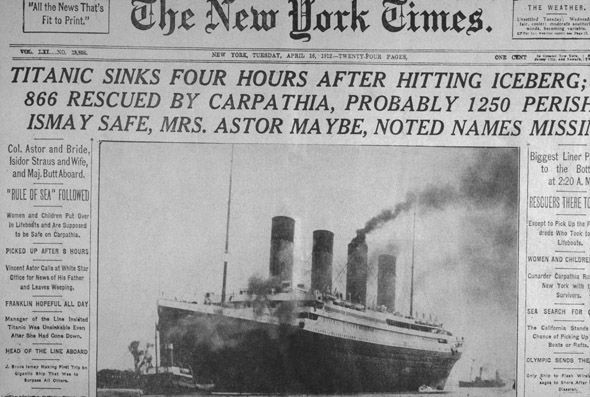

### Let's explore the data at first

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

plt.rcParams['figure.figsize'] = (10.5, 7)
plt.rcParams['font.size'] = 12

colors = ['xkcd:sky', 'xkcd:grass']
cmap = ListedColormap(colors)

In [ ]:
passengers = pd.read_excel('titanic.xls')


passengers.head()

Survival is encoded as 1, dead as 0.

Let's change that into a meaningful python data type

In [ ]:
passengers['survived'] = passengers['survived'].astype(bool)

In [ ]:
(
    passengers.survived
    .value_counts()
    .sort_index()
    .plot.pie(autopct='%.1f %%', colors=colors)
)

In [ ]:
fig, axs = plt.subplots(1, 2)

for i, (sex, group) in enumerate(passengers.groupby('sex')):
    (
        group
        .survived
        .value_counts()
        .sort_index()  # make sure the same label get's the same color
        .plot.pie(autopct='%.1f %%', colors=colors, title=sex, ax=axs[i])
    )

In [ ]:
import numpy as np
import seaborn as sns


plot_data = passengers[['fare', 'sex', 'age', 'survived']].dropna() 
plot_data['log_fare'] = np.log10(1 + plot_data['fare'])


age_range = [plot_data.age.min(), plot_data.age.max()]
fare_range = [plot_data.log_fare.min(), plot_data.log_fare.max()]
    

for sex, df_sex in plot_data.groupby('sex'):
    
    df_sex.copy().dropna(inplace=True)
    g = sns.JointGrid(x='log_fare', y='age', data=plot_data) 
    g.fig.suptitle(sex)
    
    m = g.ax_joint.scatter(
        df_sex['log_fare'],
        df_sex['age'],
        c=df_sex['survived'],
        cmap=cmap,
        s=10,
    )

    for label, group in df_sex.groupby('survived'):    
        g.ax_marg_y.hist(
            group['age'], bins=15, range=age_range, 
            histtype='step', lw=2, color=colors[label], orientation='horizontal'
        )
        g.ax_marg_x.hist(
            group['log_fare'], bins=15, range=fare_range,
            histtype='step', lw=2, color=colors[label],
        )
    
    cbar = plt.colorbar(m)
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['Died', 'Survived'])
    g.fig.tight_layout()

__The task:__

Given a vector $\boldsymbol{X} = (\mathtt{fare}, \mathtt{pclass}, \mathtt{age}, \mathtt{sex})$ can we find a function $f_\text{survival}(x) \in \{\T, \F\}$ that accurately predicts the survival of the passengers in most cases?

How do we know if that function $f_\text{survival}(x)$  is any good?

To get some sense of the quality of this predictor, we gather the following numbers:

* __True Positives__ $\TP$, The number of correctly predicted events that belong to the 'positive' class
* __False Positives__ $\FP$, The number of events falsely predicted as positive that actually belong to the 'negative' class
* __True Negatives__ $\TN$, The number of correctly predicted events that belong to the 'negative' class
* __False Negatives__ $\FN$, The number of events falsely predicted as negative that actually belong to the 'positive' class


We can look at the fraction of correctly labeled observations in the data

$$
    \mathrm{accuracy}(\v{y}, \v{\hat{y}}) = \frac{1}{N} \sum_{i = 1}^N \mathbb{1}(y_i = \hat{y}_i)
$$

or simply put 

$$
    \mathrm{accuracy}(\v{y}, \v{\hat{y}}) =  \frac{\TP + \TN}{ \TP + \FP + \FN + \TN} = \frac{\text{correctly predicted observations}}{\text{total number of observations}}.
$$


Now we try to find a function where the accuracy is higher than 0.5

__One possible solution__:

Women and children first?

In [ ]:
def f_survival(df):
    return df['sex'] == 'female'


truth = passengers['survived']
prediction = f_survival(passengers)

prediction.head()

How good are we?

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion = confusion_matrix(truth, prediction)
accuracy = accuracy_score(truth, prediction)

confusion, accuracy

In [ ]:
import seaborn as sns



def plot_confusion(truth, prediction):
    ''' We need this a couple of times, so let's make a function '''

    accuracy = accuracy_score(truth, prediction)
    confusion = confusion_matrix(truth, prediction)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3), constrained_layout=True)


    fig.suptitle(f"Accuracy {accuracy:.1%}")
    
    df = pd.DataFrame({
        'truth': pd.Series(truth).value_counts().sort_index(),
        'prediction': pd.Series(prediction).value_counts().sort_index(),
    })
    df.plot.barh(color=['gray', colors], ax=ax1, legend=False)
    
    sns.heatmap(
        confusion,
        annot=True,
        fmt="d",
        cmap='viridis',
        xticklabels=["False", "True"],
        yticklabels=["False", "True"],
        ax=ax2,
        square=True,
    )
    
    ax2.text(0.5, -0.2, 'Prediction', transform=ax2.transAxes, ha='center', va='top')
    ax2.text(-0.2, 0.5, 'Truth', transform=ax2.transAxes, ha='right', va='center', rotation=90)
    return ax1, ax2
    
plot_confusion(truth, prediction)

How can we improve the classification? 

We could try yo learn more about what happened on the Titanic. Essentially using *expert* knowledge.

Perhaps even by watching that 1997 movie where Leonardo Di Caprio drowns. 

In the movie Di Caprios character dies along with many of his third class passenger friends.

<br/>
<br/>
<br/>
<br/>
<img width="50%" src=" 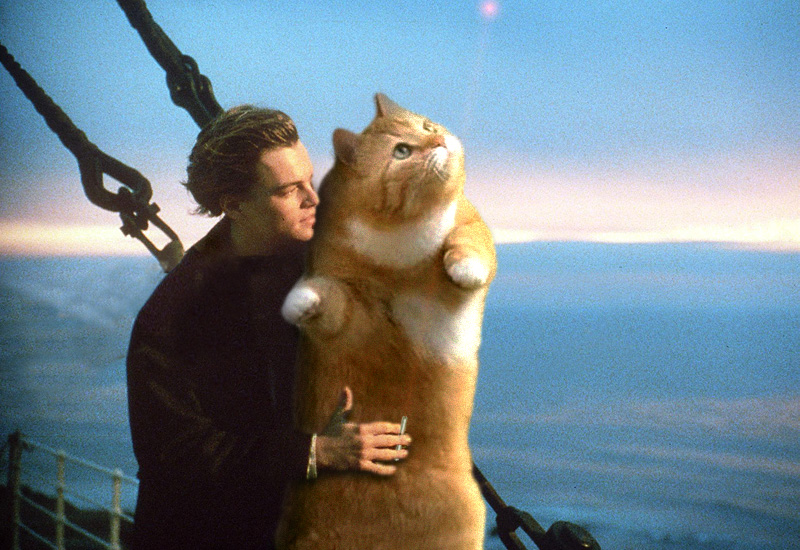"/>

Let's presume rich people get into the lifeboats

In [ ]:
def f_class(passenger_class):
    return passenger_class == 1


prediction = passengers['pclass'].apply(f_class)
truth = passengers['survived']

plot_confusion(truth=truth, prediction=prediction)

## Linear Models

Can we improve our predictor by combining more variables into one predictor?

Lets presume a linear weighted combination of variables:

$\def\RSS{\operatorname{RSS}}$

$$
f(x)= \hat{y} =  \hat{\beta}_0 + \sum_{j=1}^p x_j \hat{\beta}_j
$$
where $f:\mathbb{R}^{p} \to \mathbb{R}$.

For a single sample of the Titanic data we simply evaluate:
$$
f(x)= \hat{\beta}_0 + x_\text{Class} \hat{\beta}_1 + x_\text{Sex} \hat{\beta}_2
$$

When we include a 1 as the first entry into our sample $\v{x}$ e.g. $\v{x} = (1, x_1, x_2, \ldots, x_p)$ we can rewrite
$f$ in matrix form

$$
f(x)= \hat{y} =  \v{x}^\top \v{\beta}
$$

where $\v{\beta} = (\beta_0, \beta_1, \beta_2, \ldots, \beta_p)$.



How do you find those weights? Like before we choose a loss function and try to opimize it.
In this case we choose a loss function called the residual sum of squares (RSS).
We calculate it over all samples $x_i$ in a matrix $\boldsymbol{X}$.

<div class="important"> 

$$L(\v{\beta}) = \RSS(\v{\beta}) = \sum_{i=1}^N (y_i - \v{x}_i^\top \v\beta)^2 $$

</div>



Here $\v{x}_i$ is a row in $\v{X}$, hence the transpose.

We can now rewrite the loss function in matrix form:


$$
\RSS(\v\beta) = (\v{y} - \m{X} \v\beta)^\top (\v{y} - \m{X} \v\beta )
$$

Now we optimize the loss function just like we would any other function, by differentiating with respect to $\v\beta$ and setting the result equals to zero.

See https://en.wikipedia.org/wiki/Matrix_calculus, for how to do calculus with matrices.
We need the product rule:
$$
\frac{\partial({\v{u}} \cdot {\v{v}})}{\partial{\v{x}}}= 
 \v{u}^\top \frac{\partial \v{v}}{\partial \v{x}} + \v{v}^\top \frac{\partial \v{u}}{\partial \v{x}}
$$

For our case, this yields
$$
 2 \cdot \m{X}^T (\v{y} - \m{X} \v\beta ) \stackrel{!}{=} 0
$$

Solving for $\v\beta$ leads to

$$
\hat{\v\beta} = (\m{X}^\top \m{X})^{-1} \m{X}^\top \v{y}
$$


We just performed  __Linear Least Squares__ regression.

Now we can define a function to predict passenger survival according to

$$
\hat{y} = \begin{cases}
\T, & \text{if $ f(x) \gt 0.5$} \\
\F, & \text{if $ f(x) \le 0.5$}
\end{cases}
$$ 



### Exercise 1: Linear Regression and Classification with sklearn

Create an artificial 2D dataset with two classes and use the least squares method to seperate them.


1. Create random points in a 2D parameter space
```python
from sklearn.datasets import make_blobs
```
2. Use scikit-learn's linear regressor to find the parameters for $f(X_1, X_2) = \hat{Y}$.
```python
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, Y)
b_1, b_2 = reg.coef_
b_0 = reg.intercept_
```
3. Draw a dashed line into the plot where $f(X_1, X_2) = 0.5$.
    ```python
    x1s = np.linspace(-2, 2)
    x2s = ...

    plt.plot(x1s, x2s, color='gray', linestyle='--')
    ```


In [ ]:
# %load solutions/linear.py

We just *learned* the parameters for a statistical model based on labeled data.

Can a linear classification improve the classification of the Titanic dataset case?

### Application to the titanic dataset (Data Preparation)

But with real world datasets, things are more complicated

The Titanic dataset contains:

* Missing data (e.g. `age` and `fare`)
* Non-numeric data (e.g. `sex`)
* Categorical data (arguably `pclass`)
* Columns that are too strong of a hint for the truth  (`boat`, `body`)

#### Missing values

In [ ]:
passengers.count().sort_values()

There are different strategies, on how to solve the problem
of missing numbers.

    
* Just remove all rows and/or columns with missing numbers
* Fill in the values with values computed from the other rows, e.g. mean or more sophisticated

The second one is more complicated, because you have to make sure, you don't use
data you would not have in the test case.


In our case, just removing all rows, would mean to loose the full dataset

In [ ]:
passengers.dropna()

So we drop all columns, that contain mostly missing data

In [ ]:
missing_percentage = 1 - passengers.count() / len(passengers)

columns = missing_percentage[missing_percentage > 0.25].index
columns

In [ ]:
useful_columns = passengers.drop(columns, axis=1)

In [ ]:
nans = useful_columns.isna().any(axis=1)
useful_columns.loc[nans].head()

and then drop rows, containing nans

In [ ]:
without_missing = useful_columns.dropna()

print(len(without_missing))

without_missing.head()

or we could replace them with their respective means, this is called imputation

In [ ]:
imputed = useful_columns.copy()

imputed['age'].fillna(imputed['age'].mean(), inplace=True)
imputed['fare'].fillna(imputed['fare'].mean(), inplace=True)

print(len(imputed))
imputed.loc[nans].head()

#### Non-numeric data

In [ ]:
passengers.select_dtypes(exclude='number').head()

We can solve basically in two ways, which have slightly different semantics.


1. Just replace the string with an id number
2. Create boolean dummy columns, containing 1 or 0

The first case has the disadvantage, that it introduces ordering to something that might not have one. 
This is solved with the second method.

E.g. if we look at embarked, and replace  

S(outhhampton) → 0, C(herbourg) → 1, Q(ueenstown) → 2,   

some machine learning algorithms would now assume Q > C > S, which might be helpful or not.

In [ ]:
pd.get_dummies(passengers['embarked'], prefix='embarked').iloc[[1, 100, 300, 800]].head()

In [ ]:
pd.Categorical(passengers['embarked']).codes

#### Columns which are basically cheating

Often datasets contain columns besides the actual label, especially in the training set,
that are not available in the application case.

E.g. simulation truth values for Monte Carlo simulations in physics

It appears, some people fell of the lifeboats, froze to death or were eaten by sharks

In [ ]:
passengers.loc[~passengers.boat.isna(), 'survived'].value_counts()

In [ ]:
passengers.loc[~passengers.body.isna(), 'survived'].value_counts()

### Putting it together


In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

df = passengers.copy()

# strings to numbers
df['sex_code'] = pd.Categorical(df['sex']).codes
df = df.join(pd.get_dummies(df['embarked'], prefix='embarked'))

# remove not-useful columns (missing data, labels, not convertable)
df.drop(['body', 'cabin', 'boat', 'home.dest', 'sex', 'embarked', 'ticket', 'name'], axis=1, inplace=True)
df.dropna(inplace=True)

print(len(df))
df.head()

Evaluating performance on examples, our model has already seen, will overestimate the performance.

We have to evaluate our 'learned' model on an independent test set.

In [ ]:
X = df.drop('survived', axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_prediction = reg.predict(X_test)
y_prediction = y_prediction > 0.5

plot_confusion(truth=y_test, prediction=y_prediction)

The model does not seem to improve the classification to a large degree. 


We will talk more about properly validating models later. 

## Naive Bayes

Different classification algorithms optimize different loss functions. In the previous section we optimized the residual sum of squares. Now we will be looking at the __0-1 loss__.

<div class="important"> 
$$ L_{0,1}(\hat{Y}, Y) = 1 - \delta(Y, \hat{Y}) =    \begin{cases}
                                                    1 & {\text{if}}\quad Y \neq \hat{Y} \\
                                                    0 & {\text{else}} 
                                                \end{cases}
$$
</div>


Presume we knew $P(Y| X)$ i.e the probability for the value of the label $Y$ in presence of a data point.
Then intuitively the best classifier $f(x) = \hat{y}$ is the one that minimizes the conditional expected loss.

\begin{align}
    E(L_{0,1}(\hat{y}, y) | x) =& \sum_{y \in Y}P(y| x) L_{0,1}(\hat{y}, y) \\
            & \ldots \\
            =& 1 - P(\hat{y}| x) \\
\end{align}

Now if we minimze the expected loss given a sample $x$ while varying the predictor function $f(x) = \hat{y}$ we get   

\begin{align}
f_{*} =& \arg \min_f(E(L_{0,1}(f(x), y) | x)) \\
    =& \arg \max_{\hat{y}} \left( P(\hat{y}| x) \right) \\
    =& \arg \max_{\hat{y}}\left(P(\hat{y}) \cdot P(x | \hat{y}) \right)  \text{(used Bayes Theorem here)}\\
\end{align}

The problem is that usually the probabilities are unknown and have to be approximated using strong assumptions.

The __Naive Bayes__ classifier does exactly that, it assumes that the features are completely independent of each other and the unique (non joint) probabilities are gaussian while the prior is uniform. 

(For a more detailed mathematical derivation see the statistical methods lecture https://github.com/mackaiver/machine-learning-lecture)

For the feature distributions/likelihoods we assume a Gaussian distribution. For a feature $\mathbf{x_i}$, for example the age of a passenger, we assume a Gaussian distributions and empirically estimate both mean $\mu_k$ and standard deviation $\sigma_k$ of the samples of passengers in class $Y_k$. For a given value of an observable $v$, e.g. the age of a single passenger, we then compute 

$$
p(x=v \, | \, Y_k) \sim \mathcal{N}(\mu_k, \sigma_k)
$$

Below we perform Gaussian Naive Bayes on the Titanic dataset.



In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X = df[['sex_code', 'pclass', 'fare', 'age']]
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

reg = GaussianNB()
reg.fit(X_train, y_train)

plot_confusion(truth=y_test, prediction=reg.predict(X_test))


## Support Vector Machines (SVMs)

The basic assumption underlying the least squares approach is that the model is linear in the observed variables.

This works for data which can be separated by a linear function (a hyperplane in the parameter space).

But how do we know that this method finds the 'best' hyperplane for separating the two classes?

And what if the data cannot be seperated by a plane?


In [ ]:
# many possible lines to separate the data. Which one is 'better'?
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=150, centers=2,
                  random_state=3, cluster_std=0.70)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)

xs = np.linspace(-6.5, 3, 2)
plt.plot(xs, -2 * xs - 2, color='gray', linestyle='--')
plt.plot(xs, -0.4 * xs + 2, color='gray', linestyle='--')
plt.xlim([-6, 3])
plt.ylim([-2, 6])
plt.axis('off')
None

Support Vector Machines try to find the hyperplane which maximimizes the margin to the points in different classes in the parameter space by minimizing the so called 'Hinge Loss'

<div class="important">
$$
L(\v\beta) = C \max(0, 1 - y_i \v\beta^\top x_i)
$$
</div>

$C$ and $\lambda$ are two parameters which can be chosen beforehand. 

*Note that, to fit the definition above, the label encoding has to be $y_i \in \{-1, 1\}$*


In [ ]:
def draw_svm_decision_function(clf, X, label=None, colors='black'):
    x0_range = X[:, 0].min(), X[:, 0].max()
    x1_range = X[:, 1].min(), X[:, 1].max()

    x0, x1 = np.meshgrid(np.linspace(*x0_range), np.linspace(*x1_range))
    z = clf.decision_function(np.column_stack([x0.ravel(), x1.ravel()])).reshape(x0.shape)


    cs = plt.contour(x0, x1, z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors=colors)
    if label is not None:
        cs.collections[0].set_label(label)

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=150, centers=2,
                  random_state=3, cluster_std=1.0)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)

clf = SVC(kernel='linear')
clf.fit(X, y)

draw_svm_decision_function(clf, X, 'SVM')

reg = linear_model.LinearRegression()
reg.fit(X, y)
b_1, b_2 = reg.coef_
b_0 = reg.intercept_


x0 = np.array([X[:, 0].min(), X[:, 0].max()])
x1 = (0.5 - b_0 - b_1 * x0) / b_2

plt.plot(x0, x1, label='Linear Regression', color='gray', alpha=0.5)

plt.xlim([-6, 3])
plt.ylim([-2, 6])
plt.legend(loc='lower right', frameon=True, framealpha=0.95, facecolor='white')
None

So far the data has still been separable by a linear function. 

For many problems in real life however this isn't the case. 

Heres an example of (artificial) data which cannot be seperated by a line.

In [ ]:
from sklearn.datasets.samples_generator import make_moons

X, y = make_moons(n_samples=200, noise=0.10, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)

clf = SVC(kernel='linear')
clf.fit(X, y)
draw_svm_decision_function(clf, X, colors='black')


We can *transform* our relationship between the datapoints by using a kernel funktion 
which satisfies 
$$
k({x}_{i},{x}_{j})=\varphi ({x}_{i})\cdot \varphi ({x}_{j})
$$

In [ ]:
from mpl_toolkits import mplot3d
X, y = make_moons(n_samples=400, noise=0.10, random_state=0)


# add a dimension by applying a transformation on the two variables in the data. 
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

fig = plt.figure(figsize=(10, 5), constrained_layout=True)

for i, angles in enumerate([(45, 35), (20, -30)], start=1):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('r')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.scatter(X[:, 0], X[:, 1], r, c=cmap(y), lw=0)
    ax.view_init(*angles)

In [ ]:
X, y = make_moons(n_samples=200, noise=0.10)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)

clf = SVC(kernel='rbf', gamma='scale') #use the radial basis function instead of the linear one.
clf.fit(X, y)
draw_svm_decision_function(clf, X, colors='black', label='SVM')

The same approach works for other linear methods as well. 

What makes SVM's so special?:

+ SVM's have proven to perform very well for many use-cases.

+ SVM's handle large number of dimensions relativly fast.

+ The kernel functions basically come for free.

+ Easily extendable to multi-class problems.

+ Generalize better than comparable methods. 

Kernel functions are constrained to fulfill certain criteria. *(See Chapter 12.3.1 in the Hastie Book)*

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X = df[['sex_code', 'pclass', 'fare', 'age']]
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)


for kernel in ('linear', 'rbf', 'poly'):
    
    reg = SVC(kernel=kernel, gamma='scale')
    reg.fit(X_train, y_train)
    
    prediction = reg.predict(X_test)
    ax_bar, _ = plot_confusion(truth=y_test, prediction=prediction)
    ax_bar.set_xlim([0, 400])
    plt.suptitle(kernel + ' ' + plt.gcf()._suptitle.get_text())


None


### Extending SVMs to more dimensions

The Titanic dataset we looked at in the previous excercise had four observed variables or dimensions and 1045 observations in total. 

In [ ]:
df[['sex_code', 'pclass', 'fare', 'age']].shape


Now we take a dataset that has 64 variables. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC

# obfuscation, so you don't immediately get what we are doing here
dataset = ''.join(chr(100 + d) for d in (0, 5, 3, 5, 16, 15))
load_data = getattr(datasets, 'load_' + dataset)

X, y = load_data(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

#SVC with default settings.
clf = SVC(kernel='poly', gamma='scale')

# We learn the kernel on the first half of the data
clf.fit(X_train, y_train)

# Now predict the value of the digit on the test sample
y_prediction = clf.predict(X_test)

cm = confusion_matrix(y_test, y_prediction)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='RdPu',
)
plt.title(f'Accuracy {accuracy_score(y_test, y_prediction):.1%}')
None

__What mystery data did we just classifiy?__

The SVM can easily classifiy a dataset of many observables and target classes.

This data set had 64 observables and 10 different classes.

Lets take the 64 numbers in the single observations and plot them into a $8\times8$ grid

In [ ]:
from sklearn import datasets, svm, metrics

X, y = datasets.load_digits(return_X_y=True)

plt.figure(figsize=(13, 1))
plt.imshow([X[0]], aspect='auto', cmap='gray_r')
plt.yticks([])
None

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(10, 1))

for i, x_i in enumerate(X[:10]):
    ax = axs[i]
    img = x_i.reshape(-1, 8)
    ax.imshow(img, cmap='gray_r', interpolation='nearest')
    ax.axis('off')

This classifier just performed __character recognition__ on raw image inputs without any feature engineering.

Currently there is a lot of buzz (or even hype) about image recognition tasks and neural networks (Deep Learning etc.)
Neural networks and SVMs are very similar in nature they just use slightly modified loss functions.

For further information please checkout Stanford's computer science lecture CS231n, especially the chapter on linear classification.

[http://cs231n.github.io](http://cs231n.github.io)

## Local Optimization

So far we looked at loss functions which optimized some global optimization criterion.

We have seen that not all problems can be solved by a linear model.
It is often not possible to find a transformation, or kernel function, to transform the data into linearly separable classes.

Neither by hand nor by some automated procedure.

The idea of local optimization methods is to split the 
parameter space into subspaces where the problem is easier to solve.

### Decision Trees

Idea:
* Split the parameter space into many subspaces where observations of the same class live.

We split the space into two regions 

$$
R_1(j, s) = \{X |\, X_j \le s\}
$$

and 

$$
R_2(j, s) = \{X |\, X_j \gt s\}.
$$

These regions define half-planes in the parameter space.

In the example below we define 4 half-planes/regions to select the region in space where the blue points live. 
Now we can optimize a loss function in each of the overlapping regions.

In the example below we can simply use a decision function that is constant in each region.

$$
f(x) = \sum_{m=1}^{M} c_m \mathbb{I}(x \in R_m)
$$

where 

$$
\mathbb{I}(x \in R_m) =\begin{cases}
1,  & \text{if $x \in R_m$} \\
0, & \text{otherwise}
\end{cases}
$$

and $c_m$ is the class we assign to each region $R_m$


In [ ]:
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(n_samples=1000, noise=0.10, random_state=0, factor=0.2)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)


plt.axhspan(-0.5, 1.5, color='red', alpha=0.1)
plt.axvspan(-0.5, 1.5, color='green', alpha=0.1)

plt.axhspan(0.5, -1.5, color='blue', alpha=0.1)
plt.axvspan(0.5, -1.5, color='yellow', alpha=0.1)

plt.gca().set_aspect(1)
plt.xlim([-1.4, 1.4])
plt.ylim([-1.4, 1.4])

None

Now we choose the constant $c_m$ to be the average target value in that region. 

$$
c_m  = \frac{1}{N} \sum_{x_i \in R_m} y_i
$$

This works extremly well in the example above. The problem is to find the best splits in the parameter space.
This is an NP-Hard optimization problem, meaning it would generally take too long to solve.

It is possible to employ a greedy strategy to approximate the optimal solution. We constrain the problem of finding 
the 'best' split by only allowing binary decisions. We only allow the subspace to be split into 'left' or 'right'.

We can split the subspace by performing recursive binary splits of the subspace using the split which yields the lowest value for a given loss function.

Algorithms performing these steps are called __Decision Tree__ methods.
One advantage of binary splits is the straightforward intepretation of the results.
Here is a simple way to decide wether you should eat some pizza using a decision tree:

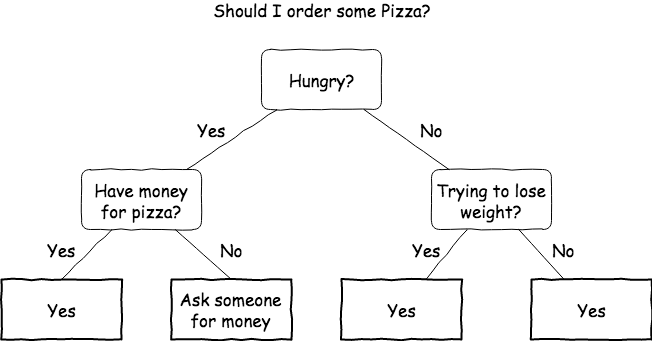

The cells below show how to train and display a decision tree using scikit-learn.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

np.random.seed(1234)

X, y = make_moons(n_samples=200, noise=0.10)
clf = DecisionTreeClassifier(max_depth=2, criterion='entropy')
clf.fit(X, y)

We call this local optimization since we only evaluate the loss function in the subspace of the data defined by the decision tree. It is local to the current node of the decision tree. 

Here is another nice explanation of entropy and information gain, the most popular los functions optimized per subspace. 
https://stackoverflow.com/questions/1859554/what-is-entropy-and-information-gain

Below is an outline (pseudo code) for building a binary decision tree:

```python
def build_tree(space)
    if stopping_criterion_fulfilled():
        return {}

    variable, split_point = find_best_split(space)

    left, right = split_space(space, variable, split_point)

    left_tree = build_tree(left)
    right_tree = build_tree(right)

    return {'node' : (variable, split_point), 'left': left_tree, 'right': right_tree}
```           

In [ ]:
def draw_decision_boundaries(clf, ax=None, cmap=cmap, alpha=0.2, **kwargs):
    if not ax:
        ax = plt.gca()

    x_low, x_high = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    x1 = np.linspace(x_low, x_high, 100)
    x2 = np.linspace(y_low, y_high, 100)

    X1, X2 = np.meshgrid(x1, x2)
    xy = np.column_stack([X1.ravel(), X2.ravel()])
    Z = clf.predict(xy).reshape(X1.shape)

    label = kwargs.pop("label", "Decision Boundary")
    # plot decision boundary and margins
    cs = ax.contourf(X1, X2, Z, **kwargs, cmap=cmap, alpha=alpha, zorder=-1)
    cs.collections[0].set_label(label)
    plt.axis("off")

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.10, random_state=0)
clf = DecisionTreeClassifier(max_depth=2, criterion='entropy')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)
draw_decision_boundaries(clf)

In [ ]:
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display  
from ipywidgets import interact


def plot_tree(crit, depth=1, min_split=0.5, min_leaf=0.2):
    estimator = DecisionTreeClassifier(
        random_state = 0,
        criterion=crit,
        splitter='best',
        max_depth=depth,
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
    )
    
    estimator.fit(X, y)

    graph = Source(tree.export_graphviz(
        estimator,
        out_file=None,
        feature_names=['Red', 'Blue'],
        class_names=['0', '1',],
        filled=True,
    ))

    display(SVG(graph.pipe(format='svg')))

    #return estimator

interact(
    plot_tree,
    crit=["gini", "entropy"],
    depth=(1, 20),
    min_split=(0.1,1),
    min_leaf=(0.1,0.5),
)

Below we apply a decision tree to the Titanic dataset while varying some parameters like depth and which loss function to use. The results are plotted into a heatmap.

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
np.random.seed(1235)

# load the data
X = df[['sex_code', 'pclass', 'fare', 'age']]
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# loop over every possible combination of parameters 
perf = pd.DataFrame()
ps = ParameterGrid({
    'max_depth': range(1, 20),
    'criterion': ['entropy', 'gini']
})

for d in ps:
    
    clf = DecisionTreeClassifier(max_depth=d['max_depth'], criterion=d['criterion'])
    clf.fit(X_train, y_train)

    acc = accuracy_score(y_test, clf.predict(X_test))
    perf = perf.append({'max_depth': d['max_depth'], 'criterion': d['criterion'], 'accuracy': acc}, ignore_index=True)

# plot a heatmap to see the best paramter combination. 
perf = perf.pivot('max_depth', 'criterion', 'accuracy')
sns.heatmap(perf, cmap='YlOrRd', annot=True, fmt='.3f', label='Accuracy')
None


### k - Nearest Neighbour Methods

The k-NN classifier is ano therlocal optimizer.

Lets assume that the decision function is constant over some local region in the parameter space:

$$
\hat{f}(x_0) = \hat{y} = \frac{1}{k} \sum_{x_i \in N_k(x_o)} y_i
$$

where $x_i \in N_k(x)$ describes the $k$ points in the training data $\mathbf{X}$ that are in the *neighbourhood* of $x_0$.

To put it in words. We assume $x$ will have the same $y$ as other points nearby.

In [ ]:
from sklearn.datasets.samples_generator import make_moons
from sklearn.neighbors import KNeighborsClassifier

X, y = make_moons(n_samples=200, noise=0.05)


knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)
draw_decision_boundaries(knn)

This works pretty well in this artifical, low-noise, example. 

Classification on noisy data will not work as good.

Real world data always has some form of noise.

In [ ]:
np.random.seed(1234)
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X, y = make_moons(n_samples=100, noise=0.2)


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for ax, n_neighbors in zip(axs, (40, 1)):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)
    draw_decision_boundaries(knn, ax=ax)
    ax.set_title(f'Accuracy for k={n_neighbors}: {accuracy_score(y, knn.predict(X)):.1%}')
    ax.axis('off')

None

## Classifier Validation 

So far we only looked at the *accuracy* measure of each classifier. We did not however compute any uncertainties on that number. There are ways to compute uncertainties on numbers like accuracy. First we try to motivate why these errors are needed.


### Overfitting (Bias-Variance Tradeoff)

The so called Bias-Variance Dillemma (or Bias-Variance Tradeoff) is a universal problem in supervised machine learning. 

There are two, often conflicting, goals we try to achieve when performing supervised machine learning:
* Optimize some parameters on some training data as much as possible
* Generalize what we learned to new data. 

This introduces two sources of errors 

* High variance of the predictior can make the learned parameters prone to noise in the training data.  
* High bias might decrease overall predictor performance.

If the parameters are tuned to the noise in the training data, or the model is too complex, the model will not generalize to new data but perform vey well on the test data.
This problem is often called __overfitting__

Below we see an example for overfitting using the k-NN classifier. We plot the accuracy of the classifier on the 
training data and the test data versus the model complexity. 

In [ ]:
k = 1
noise = 0.3

np.random.seed(0)

X, y = make_moons(n_samples=200, noise=noise)
X_test, y_test = make_moons(n_samples=100, noise=noise)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True)
fig.suptitle(f'k = {k}')
ax1.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap)
draw_decision_boundaries(knn, ax=ax1)
ax1.set_title('Accuracy on Training Data : {:.0%}'.format(accuracy_score(y, knn.predict(X))))
ax1.axis('off')

ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30, cmap=cmap)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=15, alpha=0.1,  cmap=cmap)
draw_decision_boundaries(knn, ax=ax2)
ax2.set_title('Accuracy on Test Sample: {:.0%}'.format(accuracy_score(y_test, knn.predict(X_test))))
ax2.axis('off')
None

In [ ]:
np.random.seed(1234)

X, y = make_moons(n_samples=400, noise=0.2)
X_test, y_test = make_moons(n_samples=400, noise=0.2)

e_train = []
e_test = []

param_range = np.arange(1, 200)

for p in param_range:
    clf = KNeighborsClassifier(n_neighbors=p)    
    clf.fit(X, y)

    e_train.append(1- accuracy_score(y, clf.predict(X)))
    e_test.append(1 - accuracy_score(y_test, clf.predict(X_test)))
    


In [ ]:
plt.plot(param_range, e_train,'.', color='#FF6B6B', ms=10, label='Training Sample')
plt.plot(param_range, e_test, '.' ,color='#FFAE6B', ms=10, label='Test Sample', )

plt.xlim(param_range[-1], param_range[0])
plt.xlabel('k')
plt.ylabel('Prediction Error')

plt.text(150, 0.026, 'Increasing Model Complexity')
plt.arrow(150, 0.018, -50, 0, width = 0.0005, head_width=0.003, head_length=3, fc='k', ec='k')
plt.legend()

### Validation on independent test sets

Validating the fitted models is essential for avoiding overfitting.

The predictions error has to be assesed on an independent test dataset. 

Models might still be susceptible to noise in the training data.

#### Cross Validation

A $k$-fold cross validation automatically splits the training data into $k$ subsets.

The model is then trained on $k-1$ subsets and evaluated on the remaining set. 

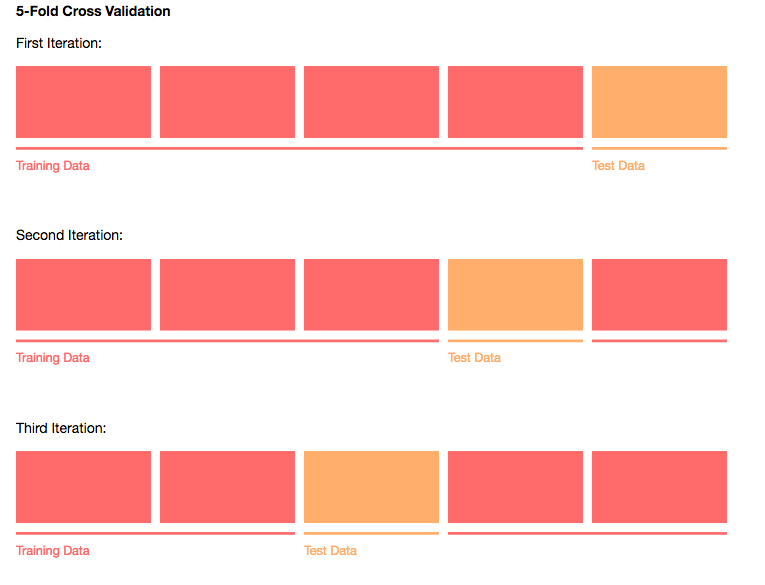

Below we use sklearn's cross validation method to estimate the accuracy of a Decision Tree  classifier on many independent test sets. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate


X = df[['sex_code', 'pclass', 'fare', 'age']]
y = df['survived']

clf = DecisionTreeClassifier(max_depth=5)
r = cross_validate(clf, X=X, y=y, cv=5, scoring=['accuracy'], return_train_score=True)

print('Accuracy on test sets: {:.0%} ± {:.0%}'.format(r['test_accuracy'].mean(), r['test_accuracy'].std() ))
print('Accuracy on training sets: {:.0%} ± {:.0%}'.format(r['train_accuracy'].mean(), r['train_accuracy'].std() ))


#### Other Quality Metrics

Accuracy is not always a good measure of model quality.

Imagine a classifier function which simply predicts a fixed outcome.

        def f_fixed(x):
            return 0
            
On an imbalanced dataset this classifier will have an accuracy equal to the ratio of positive examples to the total number of examples.

In [ ]:
def f_fixed(x):
    return np.zeros(shape=len(x))


X = df[['sex_code', 'pclass', 'fare', 'age']]
y = df['survived']

print('Accuracy of fixed classifier {:1.6f} \n'.format(accuracy_score(y, f_fixed(X))))

print('Ratio of survived to total passengers: ')
print(df.survived.value_counts(normalize=True))


Another view at the confusion matrix. It generalizes to more than two classes as seen in the picture below.

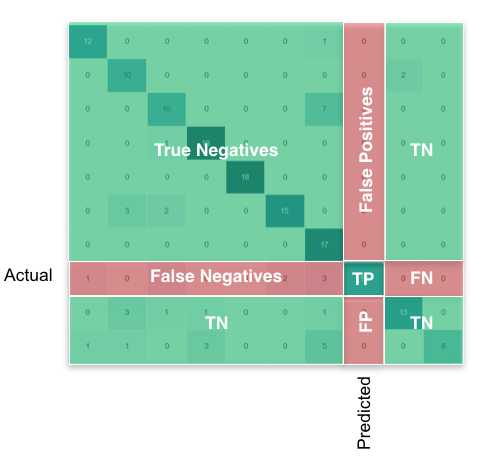

The numbers in the confusion matrix can be used to calculate a whole range of quality criteria.

Lets build a classifier which randomly chooses an outcome and look at the different criteria.

```
def f_random(passenger):
    return np.random.choice(['yes', 'no')
```


<a href="https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal" style="color:#BBBBBB;">The nice Stack Overflow post where I stole the picture from.</a>



In [ ]:
def f_random(x):
    return np.random.randint(2, size=len(x))

prediction = f_random(X)

cm = confusion_matrix(y, prediction)

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

perf = {}
# Sensitivity, hit rate, recall, or true positive rate
perf['TPR'] = TP/(TP+FN)
# Specificity or true negative rate
perf['TNR'] = TN/(TN+FP) 
# Precision or positive predictive value or purity
perf['PPV'] = TP/(TP+FP)
# Negative predictive value
perf['NPV'] = TN/(TN+FN)
# Fall out or false positive rate
perf['FPR'] = FP/(FP+TN)
# False negative rate
perf['FNR'] = FN/(TP+FN)
# False discovery rate
perf['FDR'] = FP/(TP+FP)

# Overall accuracy
perf['ACC'] = (TP+TN)/(TP+FP+FN+TN)

for k, v in perf.items():
    print(k, np.round(v, 2))

In [ ]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(y, prediction))
print(precision_score(y, prediction))

Precision and recall can be understood in an intuitive way

* __Recall__ How many of the wanted examples are found.
* __Precision__ The percentage of the found examples that are actually relevant.

So what should you optimize for? Maximumg accuracy or precision or recall?

There is no clear answer.  
It depends on your use-case.  
Can you tolerate false positives?   
Can you tolerate losing some true positives?  

We will always have to make the trade-off between recall and precission. 
There are several metrics which try to combine both into one.

The $f_{\beta}$ score is one example.

$$
f_{\beta } = (1+\beta ^{2})\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{(\beta ^{2}\cdot \mathrm {precision} )+\mathrm {recall} }} =
\frac {(1 + \beta^2) \cdot TP }{(1 + \beta^2) \cdot TP + \beta^2 \cdot FN + FP}.
$$

But in the end there is no absolute truth to what's best.


Imagine you devise a new, cheap and easy cancer test.   
What should you optimize your decision threshold for?
Precision or recall?

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

np.random.seed(1234)

X = df[['sex_code', 'pclass', 'fare', 'age']]
y = df['survived']

svc = SVC(kernel='linear')
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(max_depth=5)

results = []
for clf, name in zip([svc, knn, tree], ['SVM', 'kNN', 'tree']):
    r = cross_validate(
        clf, X=X, y=y, cv=5,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        return_train_score=False,
    )
    perf = pd.DataFrame.from_dict(r)
    perf['classifier'] = name
    results.append(perf)

perf = pd.concat(results).drop(['fit_time', 'score_time'], axis='columns')

means = perf.groupby('classifier').mean()
deviations = perf.groupby('classifier').std()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(means, cmap='viridis', annot=True, ax=ax1, vmin=0, vmax=1)
sns.heatmap(deviations, cmap='viridis', annot=True, ax=ax2, vmin=0, vmax=1)


## Decision Thresholds and Classifier Validation

Classifier objects usually provide all of the following methods

* `classifier.fit(X)` takes training data and finds some parameters based on that data.
* `classifier.predict(X_new)` takes new data (one row or many) and predicts the target label for each row.
* `classifier.predict_proba(X_new)` takes new data (one row or many) and predicts 'some notion of confidence'.

In the case of binary classification (i.e. two classes) the `classifier.predict_proba` usually returns a number where higher numbers indicate some measure of 'confidence'.

The `classifier.predict(X_new)` is basically a wrapper around the `predict_proba` function which simply applies a decision threshold at some value (usually 0.5).
This is exactly what we did in the case of linear least squares regression.


$$
\hat{Y} = \begin{cases}
\text{Yes}, & \text{if $ f(X) \gt 0.5$} \\
\text{No}, & \text{if $ f(X) \le 0.5$}
\end{cases}
$$

In this case the decision threshold corresponds to the distance of a point to the seperating hyperplane.

Below we see two overlapping blobs of points. A seperating line is drawn in between the two populations. 
Intuitively we can associate a higher degree of 'certainty' regarding class membership to points farther away from the line.

In [ ]:
X, y = make_blobs(n_samples=200, centers=2, random_state=3, cluster_std=1.70)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)

xs = np.linspace(-6.5, 3, 2)
plt.plot(xs, -0.4 * xs + 2, color='gray', linestyle='--')
circle = plt.Circle((-2, 3), 0.15, fc='black')
plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.gca().annotate('Which class?', xy=(-2, 3), xytext=(3.5, 4), arrowprops=dict(facecolor='gray', shrink=0.05),)

plt.axis('off')
None

#### Varying the Threshold

Varying the decision threshold is extremely useful for modifying your classifier output to create more/less 
'conservative' predictions.


In essence this is a new classifier/predictor with a free parameter. The old $\hat{y} = \hat{f}(x)$ now becomes

$$
\hat{y} = \hat{f}(x, \alpha)
$$

where $\alpha$ is a parameter which can be chosen freely (or optimized according to some criterion which has 
nothing to do with the underlying loss function of the predictor.)

The example below shows how the number of true positives can be influenced by varying the threshold $\alpha$

In [ ]:
N = 2000
X, y = datasets.make_moons(n_samples=N, noise=0.3)
X_test, y_test = datasets.make_moons(n_samples=N, noise=0.3)


clf = DecisionTreeClassifier(max_depth=5, criterion='entropy')
clf.fit(X, y)
y_predicted = clf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 50)

tp = [(y_predicted > t).sum()/N for t in thresholds]
plt.plot(thresholds, tp, label='Decision  Tree')


clf = SVC(probability=True, gamma='scale')
clf.fit(X, y)
y_predicted = clf.predict_proba(X_test)[:, 1]

tp = [(y_predicted > t).sum()/N for t in thresholds]
plt.plot(thresholds, tp, label='SVM')

plt.legend()
plt.xlabel('prediction')
plt.ylabel('true positives')
None

#### Receiver Operating Characteristic 

The decision threshold is incredibly helpful in validating classifier performance.

The plot of false positive rate vs. true positive rate while varying the decision threshold is called the Receiver Operating Characteristic curve (ROC curve).

It is a very popular tool for classifier performance evaluation.

Wikipedia Quote:

> Following the attack on Pearl Harbor in 1941, the United States army began new research to increase the prediction of correctly detected Japanese aircraft from their radar signals. For this purposes they measured the ability of radar receiver operators to make these important distinctions, which was called the Receiver Operating Characteristics.


A classifier which assigns random labels to the data will have a ROC curve which lies on the diagonal. With an area under curve (AUC) of 0.5.


__Problems__

There are circumstance in which the ROC is not a good measure of quality. 

See https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve for a discussion.

Also in the case of imbalanced classes (eg. imagine you had 10000 surviors but 10 deceased passengers) the ROC curve itself won't change. The intepretation of the ROC curve however changes drastically.

In that case its better to plot the precission vs recall curve and the corresponding area under curve.

See https://classeval.wordpress.com for some very good discussions on classifier evaluation.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve

X, y = make_classification(n_samples=10000, n_features=10, n_informative=2, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y)

prediction = KNeighborsClassifier(n_neighbors=220).fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, t = roc_curve(y_test, prediction)
t[0] = 0 # do this for nicer plotting. it is set to 2 otherwise ruiing the colormap
print(t.max())
plt.figure(figsize=(12, 10))
plt.scatter(fpr, tpr, c=t, cmap='viridis', s=50)
plt.colorbar(label='Decision Threshold')
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Ensemble Methods

We have used a decision tree to classifiy artificial data as well as the Titanic data. 

Theoretically a decision tree is not limited in its depth. 

This quickly leads to overfitted tree models.


### Bagging

A popular way to build ensembles is called *bagging*.

Split the training data into $B$ subsets using sampling with replacement (Bootstrapping). For each subset $b$ we train a classifier $\hat{f}_b$. Bagging then combines the overall prediction by taking the average.  

$$
\hat{y} = \hat{f}_{\text{bag}}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}_b (x) 
$$

### Random Forests

Random Forests are a modification to bagging in which a number of *randomized decision trees* are trained. These randomized decision trees use a random subset of variables to find the best split in each node.


Random Forests are a very popular choice for classification tasks since their parameters can be easily tuned and they often outperform other methods.

In [ ]:
np.random.seed(2)
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



X = df[['sex_code', 'pclass', 'fare', 'age']]
y = df['survived']

tree = DecisionTreeClassifier(min_samples_leaf=5)

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)

np.random.seed(0)
score = cross_validate(tree, X, y, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Decision Tree {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
np.random.seed(0)
score = cross_validate(tree, X, y, scoring=make_scorer(accuracy_score), cv=5)
print('Accuracy {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

np.random.seed(0)
score = cross_validate(rf, X, y, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
np.random.seed(0)
score = cross_validate(rf, X, y, scoring=make_scorer(accuracy_score), cv=5)
print('Accuracy {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

## Regression

Regression and classification are very similar in nature. The biggest difference being that the target variable $y$ is continous and has a natural ordering associated with it. 

The same basic rules for classification apply for regression as well. 

* Models need to be verified on independent test data
* There is a tradeoff between bias and variance. Overfitting can occur.
* There are many quality measures to pick from. 

The loss functions we are minimizing need to be adapted. 
For classification the loss function for the decision tree was based on entropy. The one for the Naive Bayes 
classifier was the 0-1 loss. Both are designed to improve classification. 

To make a regressor out of a decision tree we can change the loss function to minimize the variance of the 
target variable in the node. 

To find the best split, we minimize the variance of the target , $\mathit{Var(y)}$,  over all features  $X \in 
\mathbf{X}$ and splits $s$

The algorithm stays the same we simply changed the way to select the features in each step according to 

$$
  \min_{(X, s) \in \, \mathbf{X} \times {S}}Var(Y_S)
$$

where $Y_S$ are the values of the target variable in the subspace created by splitting the data on the feature $X$ at a value $s$ 



### Example: Boston Housing

A typical example of a regression task. Given some information about housing in the larger Boston area try and predict the price of the object.

There are 14 attributes in each case of the dataset. They are:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per \$10,000
- PTRATIO - pupil-teacher ratio by town
- B - $1000(Bk - 0.63)^2$ where Bk is the fraction of african-american citizens by town
- LSTAT - percent lower status of the population
- MEDV - Median value of owner-occupied homes in \$1000's


Our regression task is to predict the price of a house from the 13 given variables. From a plot of some of the variables we can see some weak correlations in some variables.

None of these variables alone would suffice to build a good predictor. Hence we try to use multivariate regression methods.

In [ ]:
from sklearn.datasets import load_boston

houses = load_boston()
names = list(houses.feature_names) +  ['price']
data = pd.DataFrame(data=np.c_[houses['data'], houses['target']], columns=names)

In [ ]:
sns.pairplot(data[['RM', 'NOX', 'B', 'price']])

In [ ]:
sns.jointplot(data.RM, data.price, kind='scatter')

The question this data set can help us answer is:

> What is the price of a house based on geographical criteria?

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_validate

X, y = load_boston(return_X_y=True)

reg = LinearRegression()
score = cross_validate(reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Score linear regression {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

reg = SVR(kernel='rbf', gamma='scale')
score = cross_validate(reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Score SVR {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

reg = DecisionTreeRegressor()
score = cross_validate(reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Score Tree {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

reg = RandomForestRegressor(n_estimators=100)
score = cross_validate(reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Score RandomForestRegressor {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()

X_train, X_test, y_train, y_test = train_test_split(houses.data, houses.target, test_size=0.5)
reg.fit(X_train, y_train)
prediction = reg.predict(X_test)

bin_edges = np.linspace(0, 60, 30)
plt.hist2d(prediction, y_test, bins=bin_edges, cmap='gray_r',)
plt.colorbar()
plt.grid()
plt.plot([0, 60], [0, 60], color='gray')
None

### Regression is not Curve Fitting

The output of the predictor shows stronger correlation than any of the other variables. It is still noisy and shows some smearing and outliers. The output of a regressor should never be understood as 'true' but rather as a new correlated variable which can show noise and bias. 


There is a fundamental difference between *curve fitting* and regression.

* __Curve Fitting__ All data is available. Some known (or presumed) analytical function is fit to the data to estimate free parameters of that function.


* __Regression__ Training data is available. A model is fitted on training data to predict the dependent variable on some new, unknown, data.

There is a lot more to learn about linar models and regression. Check sklearn's user guide on linear models for more information 
http://scikit-learn.org/stable/modules/linear_model.html

A very popular regression metric is the $R^2$ score. Read about it here

https://en.wikipedia.org/wiki/Coefficient_of_determination

and here

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html .

# More Material

Statistical Methods Lecture at TU Dortmund (the basis for this notebook with more math): 
https://github.com/mackaiver/machine-learning-lecture 


Read scikit-learns's user guide. It's detailed and describes pros and cons of many alogirthms and evaluation criteria. Its also full of code examples.

http://scikit-learn.org/stable/user_guide.html

Read the book by Hastie (if you're a crazy maths person)

http://web.stanford.edu/~hastie/ElemStatLearn/

Read this book by James and Hastie (if you're a normal person)

http://www-bcf.usc.edu/~gareth/ISL/